In [30]:
import numpy as np
import pandas as pd
from elftools.elf.elffile import ELFFile
import matplotlib.pyplot as plt
from riscemu.decoder.decoder import decode as decode_instr
import struct
import sys

In [31]:
# SavedVariables file as saved by the addon
PROFILING_FILE_PATH = "/mnt/c/Program Files (x86)/World of Warcraft/_retail_/WTF/Account/101559159#1/SavedVariables/DoomWithin.lua"
# Doomgeneric binary file
BINARY_PATH = "/mnt/c/Users/kochu/Code/wow/doomgeneric/build/bin/doomgeneric"

In [32]:
def parse_prof_file(path):
    with open(path, 'r') as f:
        raw = f.read()
        records_raw = raw.split('{\n{')[1].split('},\n}')[0].split('},\n{')
        records_str = [
            x.split(',\n')
            for x
            in records_raw
        ]

        types = (int, int, int, int, float)
        names = ('pc', 'ra', 'r7', 'instr', 't')
        records = [
            {name: dtype(val) for name, dtype, val in zip(names, types, x)}
            for x
            in records_str
        ]
        return records
        
        
prof_records = parse_prof_file(PROFILING_FILE_PATH)
len(prof_records), prof_records[0]

(1993001,
 {'pc': 366064,
  'ra': 66128,
  'r7': 0,
  'instr': 17237779,
  't': 0.001100003719329834})

In [33]:
prof_df = pd.DataFrame.from_dict(prof_records)
prof_df

,pc,ra,r7,instr,t
0,366064,66128,0,17237779,0.0011
1,366056,66128,0,12002339,0.0008
2,366048,66128,0,12001315,0.0006
3,366064,66128,0,17237779,0.0004
4,366056,66128,0,12002339,0.0005
...,...,...,...,...,...
1992996,332784,273572,4293160104,1017747,0.0004
1992997,273648,273892,105,67174675,0.0005
1992998,258208,273572,27816,18253491,0.0005
1992999,273428,273572,105,675391363,0.0006


In [34]:
syscalls = {
    93: "exit",
    64: "write",
    101: "togglewindow",
    102: "render_framebuffer",
    103: "get_key_state",
    104: "sleep",
    105: "draw_column",
    106: "draw_span",
    107: "draw_patch",
    108: "memcpy",
    80: "newfstat",
    57: "fclose",
    214: "brk",
    403: "clock_gettime",
}

In [35]:
def load_sym_table(path):
    with open(path, 'rb') as f:
        elf = ELFFile(f)
        symtab = elf.get_section_by_name('.symtab')
        symbol_lookup = {}
        for sym in symtab.iter_symbols():
            addr = sym.entry.st_value
            for i in range(sym.entry.st_size):
                symbol_lookup[addr + i] = sym.name
        return symbol_lookup
symbol_lookup = load_sym_table(BINARY_PATH)
len(symbol_lookup), len(set(symbol_lookup.values()))

(4943826, 1952)

In [36]:
prof_df['symbol'] = prof_df.apply(lambda row: symbol_lookup.get(row.pc), axis=1)
prof_df['ra_symbol'] = prof_df.apply(lambda row: symbol_lookup.get(row.ra), axis=1)
prof_df['instr_decoded'] = prof_df.apply(lambda row: decode_instr(struct.pack('I', row.instr)), axis=1)


def inst_decoder(row):
    if row.instr_decoded[2] == 115: # ecall
        return f'ecall({syscalls[row.r7]})'
    return str(row.instr_decoded)
prof_df['instr_decoded_str'] = prof_df.apply(inst_decoder, axis=1)


In [37]:
prof_df#[prof_df['instr']==115]

,pc,ra,r7,instr,t,symbol,ra_symbol,instr_decoded,instr_decoded_str
0,366064,66128,0,17237779,0.0011,memset,_start,"(addi, [14, 14, 16], 17237779)","('addi', [14, 14, 16], 17237779)"
1,366056,66128,0,12002339,0.0008,memset,_start,"(sw, [11, 14, 8], 12002339)","('sw', [11, 14, 8], 12002339)"
2,366048,66128,0,12001315,0.0006,memset,_start,"(sw, [11, 14, 0], 12001315)","('sw', [11, 14, 0], 12001315)"
3,366064,66128,0,17237779,0.0004,memset,_start,"(addi, [14, 14, 16], 17237779)","('addi', [14, 14, 16], 17237779)"
4,366056,66128,0,12002339,0.0005,memset,_start,"(sw, [11, 14, 8], 12002339)","('sw', [11, 14, 8], 12002339)"
...,...,...,...,...,...,...,...,...,...
1992996,332784,273572,4293160104,1017747,0.0004,DG_DrawColumn,R_DrawMaskedColumn,"(addi, [15, 31, 0], 1017747)","('addi', [15, 31, 0], 1017747)"
1992997,273648,273892,105,67174675,0.0005,R_DrawMaskedColumn,R_DrawVisSprite,"(addi, [2, 2, 64], 67174675)","('addi', [2, 2, 64], 67174675)"
1992998,258208,273572,27816,18253491,0.0005,R_DrawColumn,R_DrawMaskedColumn,"(add, [13, 13, 17], 18253491)","('add', [13, 13, 17], 18253491)"
1992999,273428,273572,105,675391363,0.0006,R_DrawMaskedColumn,R_DrawMaskedColumn,"(lw, [15, 3, 644], 675391363)","('lw', [15, 3, 644], 675391363)"


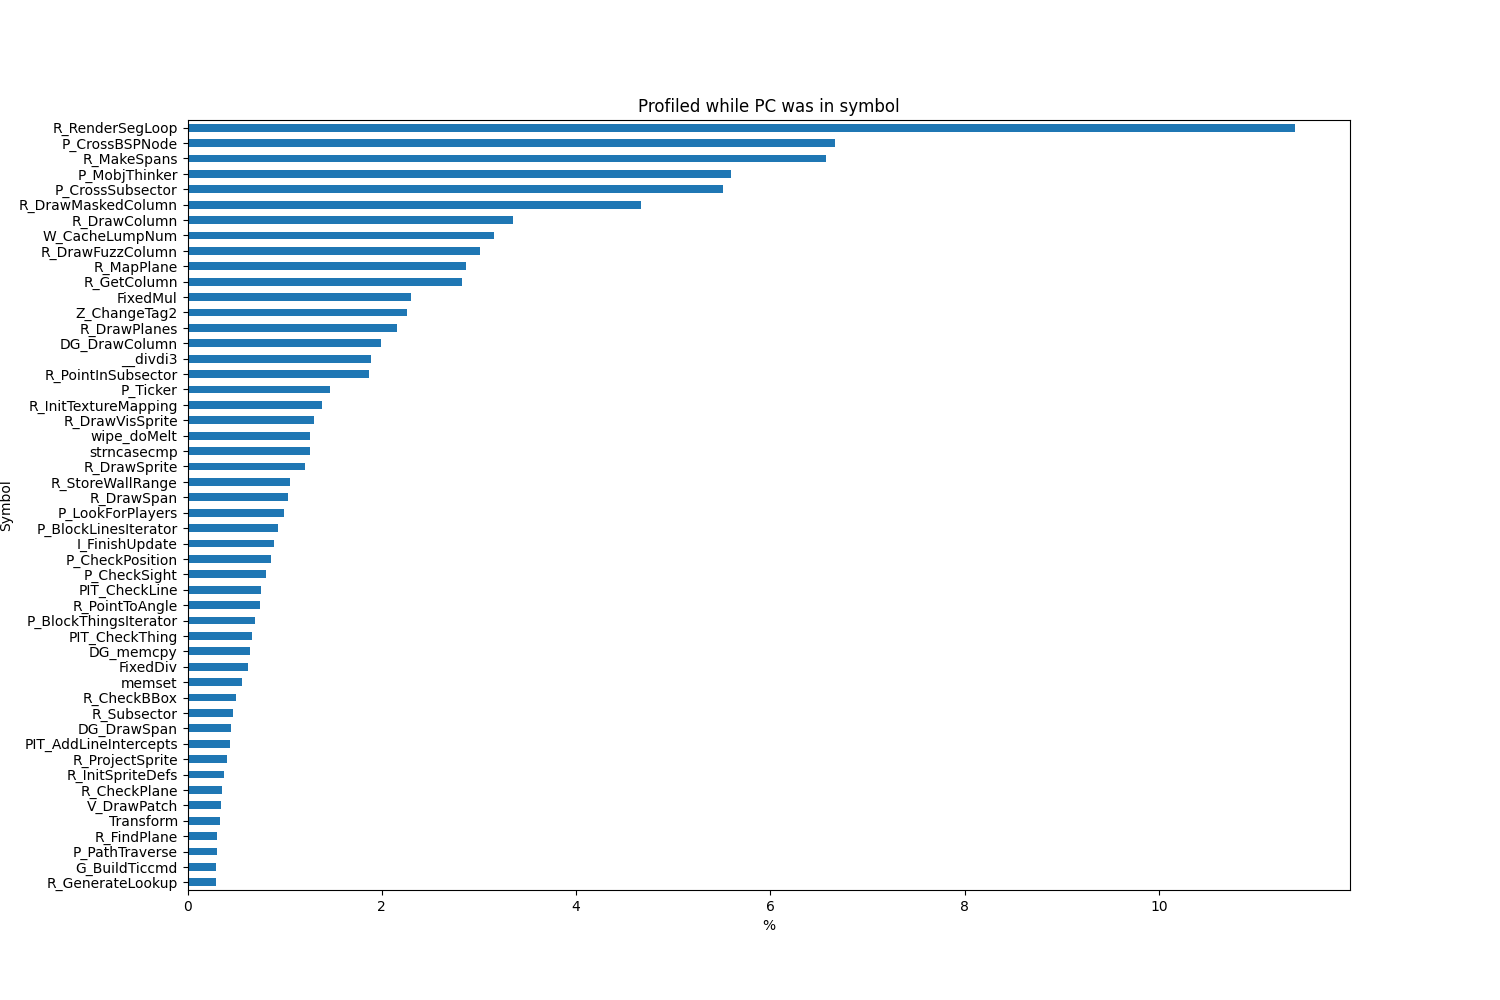

In [38]:
%matplotlib widget

symbol_counts = prof_df['symbol'].value_counts()
symbol_percent = (symbol_counts / symbol_counts.sum()) * 100

top_symbol_percent = symbol_percent.head(50)

plt.figure(figsize=(15, 10))
top_symbol_percent.sort_values(ascending=True).plot(kind='barh')

plt.xlabel('%')
plt.ylabel('Symbol')
plt.title('Profiled while PC was in symbol')

plt.show()

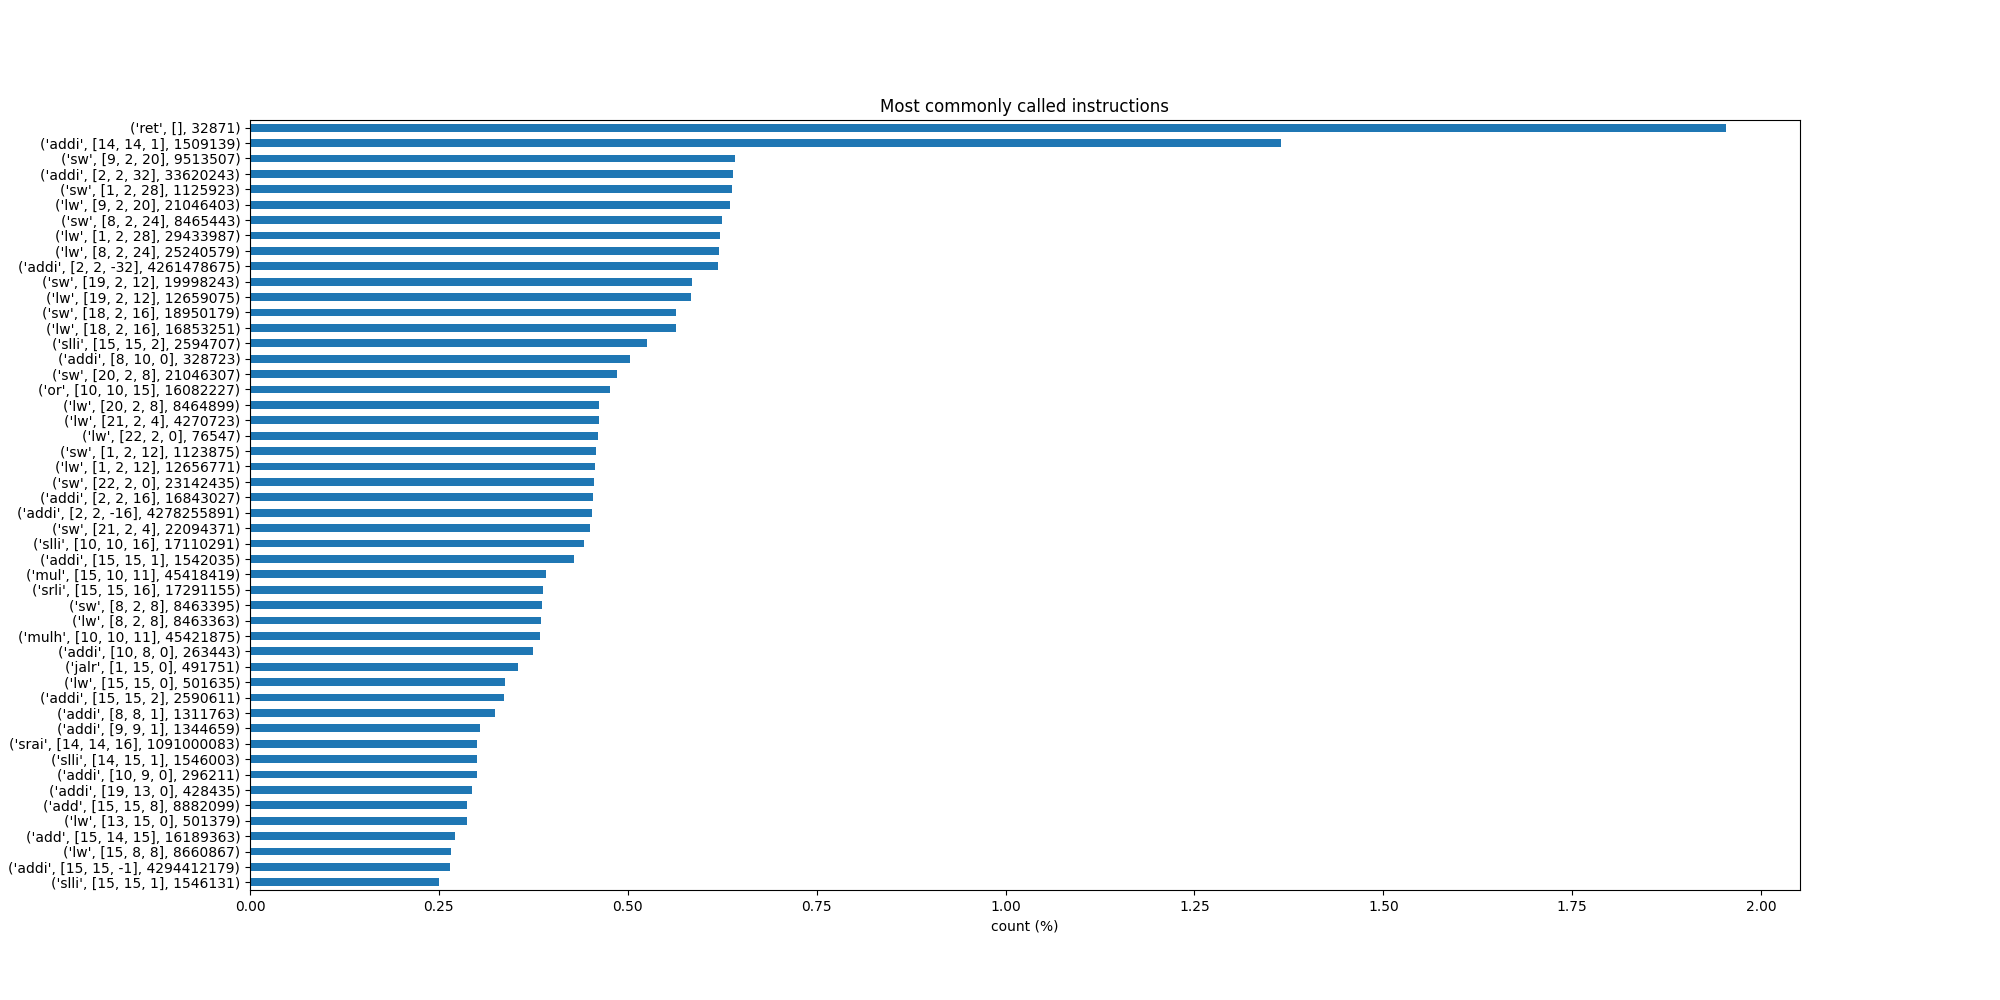

In [39]:
%matplotlib widget

symbol_counts = prof_df['instr_decoded_str'].value_counts()
symbol_percent = (symbol_counts / symbol_counts.sum()) * 100

top_symbol_percent = symbol_percent.head(50)

plt.figure(figsize=(20, 10))
top_symbol_percent.sort_values(ascending=True).plot(kind='barh')

plt.xlabel('count (%)')
plt.ylabel('instruction')
plt.title('Most commonly called instructions')

plt.show()

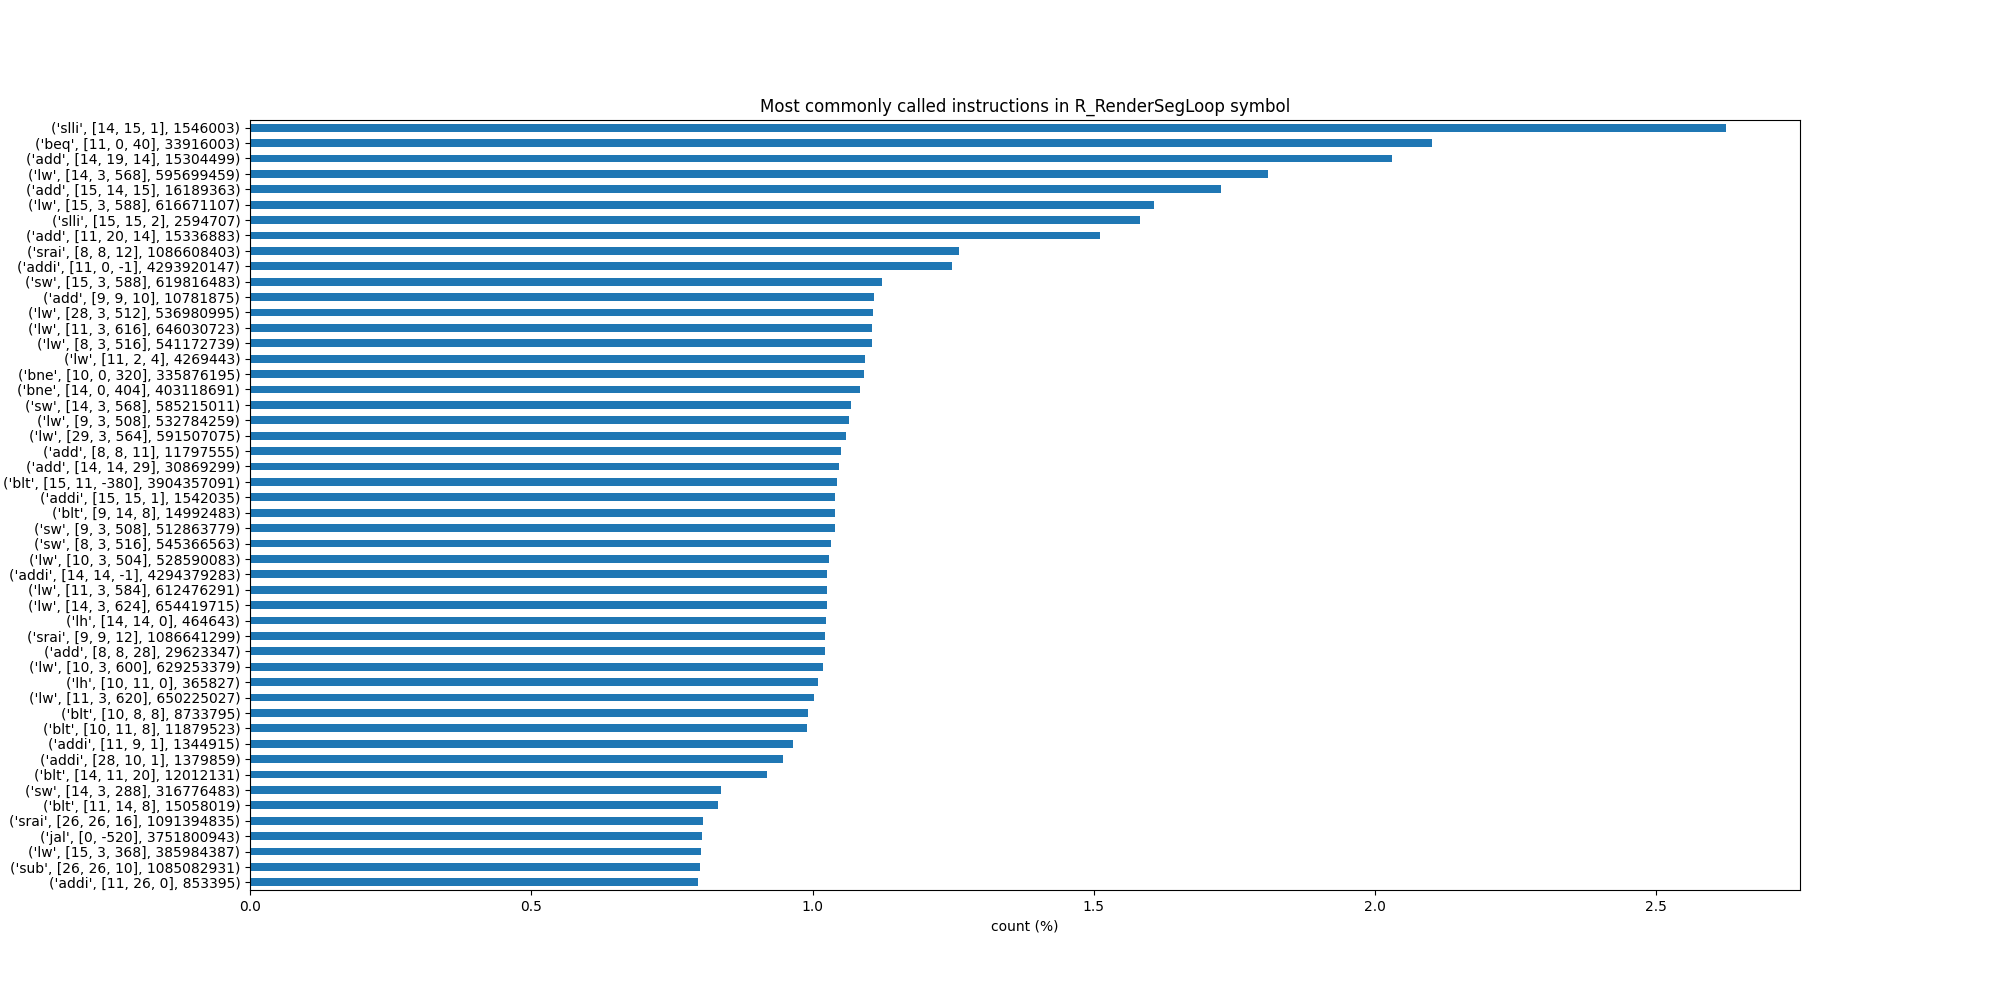

In [40]:
%matplotlib widget

symbol = 'R_RenderSegLoop'
#symbol = 'DG_memcpy'

symbol_counts = prof_df[prof_df['symbol']==symbol]['instr_decoded_str'].value_counts()
symbol_percent = (symbol_counts / symbol_counts.sum()) * 100

top_symbol_percent = symbol_percent.head(50)

plt.figure(figsize=(20, 10))
top_symbol_percent.sort_values(ascending=True).plot(kind='barh')

plt.xlabel('count (%)')
plt.ylabel('instruction')
plt.title(f'Most commonly called instructions in {symbol} symbol')

plt.show()

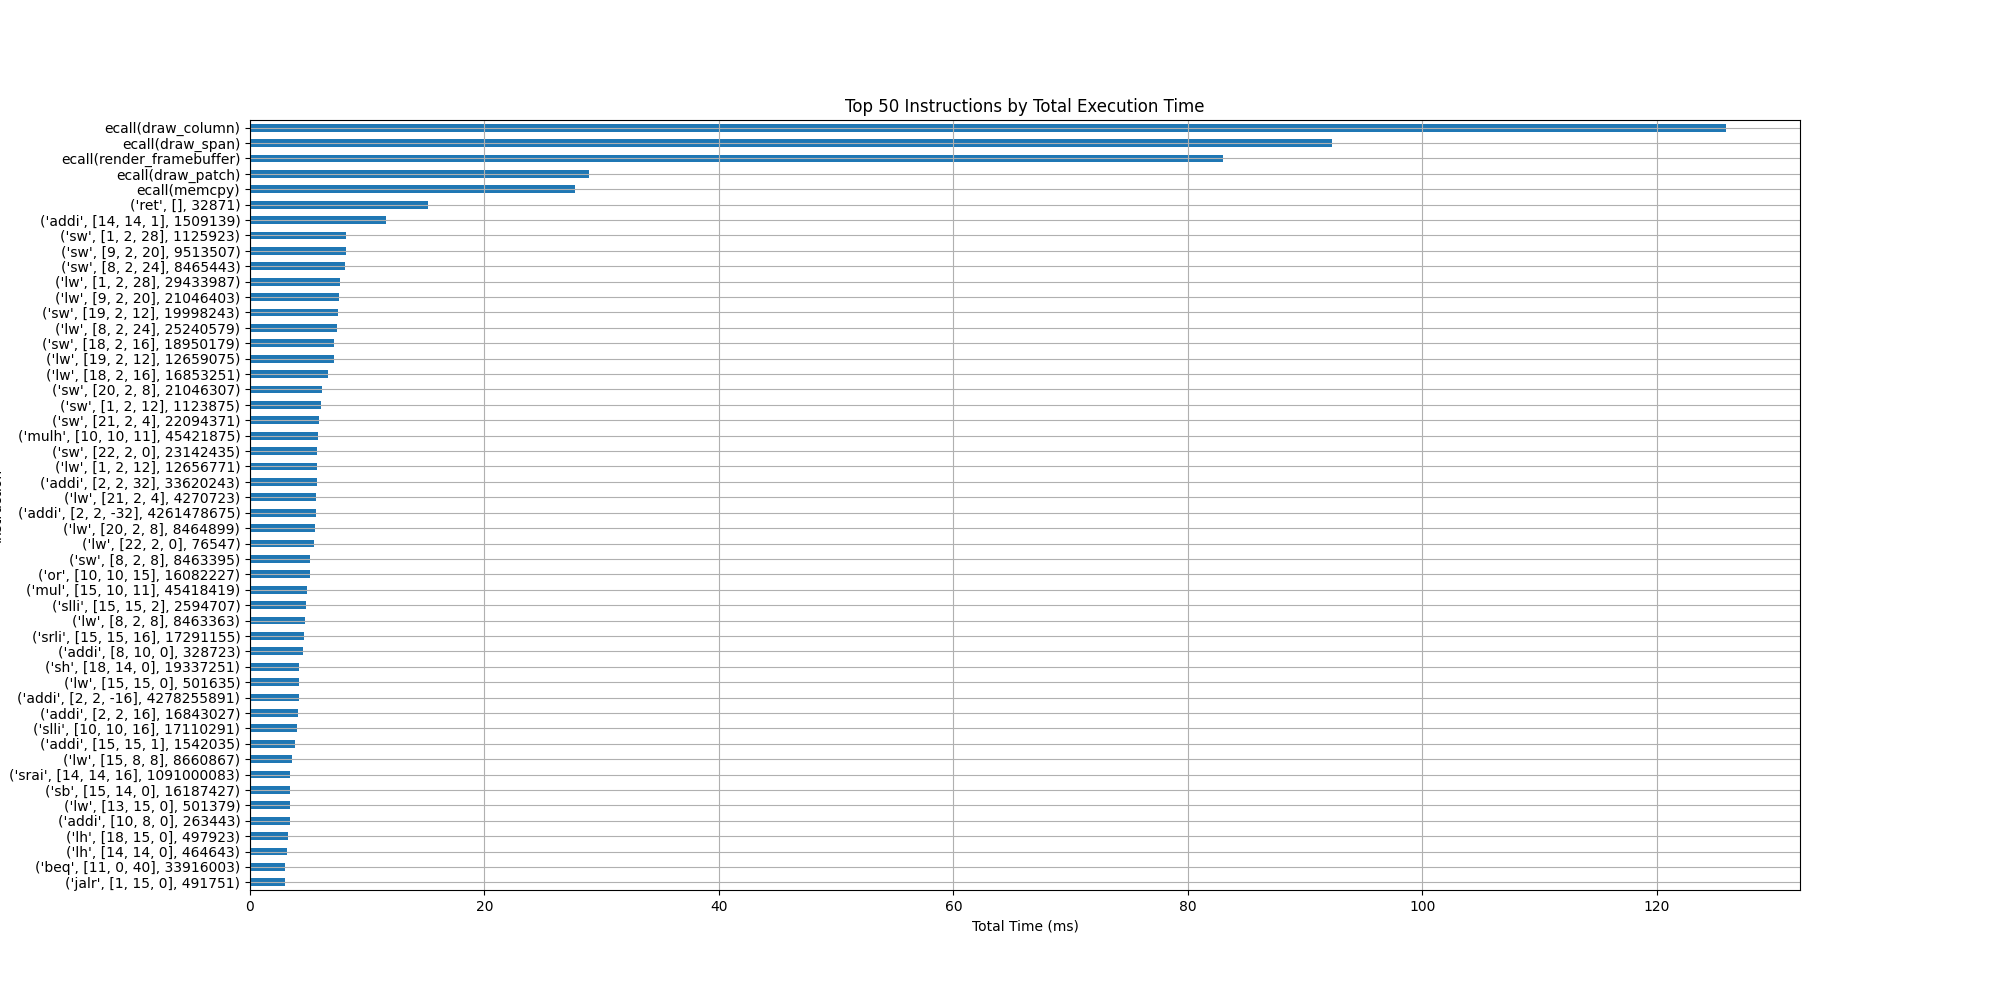

In [41]:

total_time = prof_df.groupby('instr_decoded_str')['t'].sum()

top_k = 50

top_total_time = total_time.nlargest(top_k)

plt.figure(figsize=(20, 10))
top_total_time.sort_values(ascending=True).plot(kind='barh')

plt.xlabel('Total Time (ms)')
plt.ylabel('Instruction')
plt.title(f'Top {top_k} Instructions by Total Execution Time')
plt.grid()
# Show the plot
plt.show()

In [42]:
#not_ecall = prof_df['ecall' in prof_df['instr_decoded_str']]["t"].sum()
#ecall = prof_df['ecall' in prof_df['instr_decoded_str']]["t"].sum()
#print(f"Total: {not_ecall + ecall}\nNot ecall: {not_ecall / (not_ecall + ecall)}\necall: {ecall / (not_ecall + ecall)}")

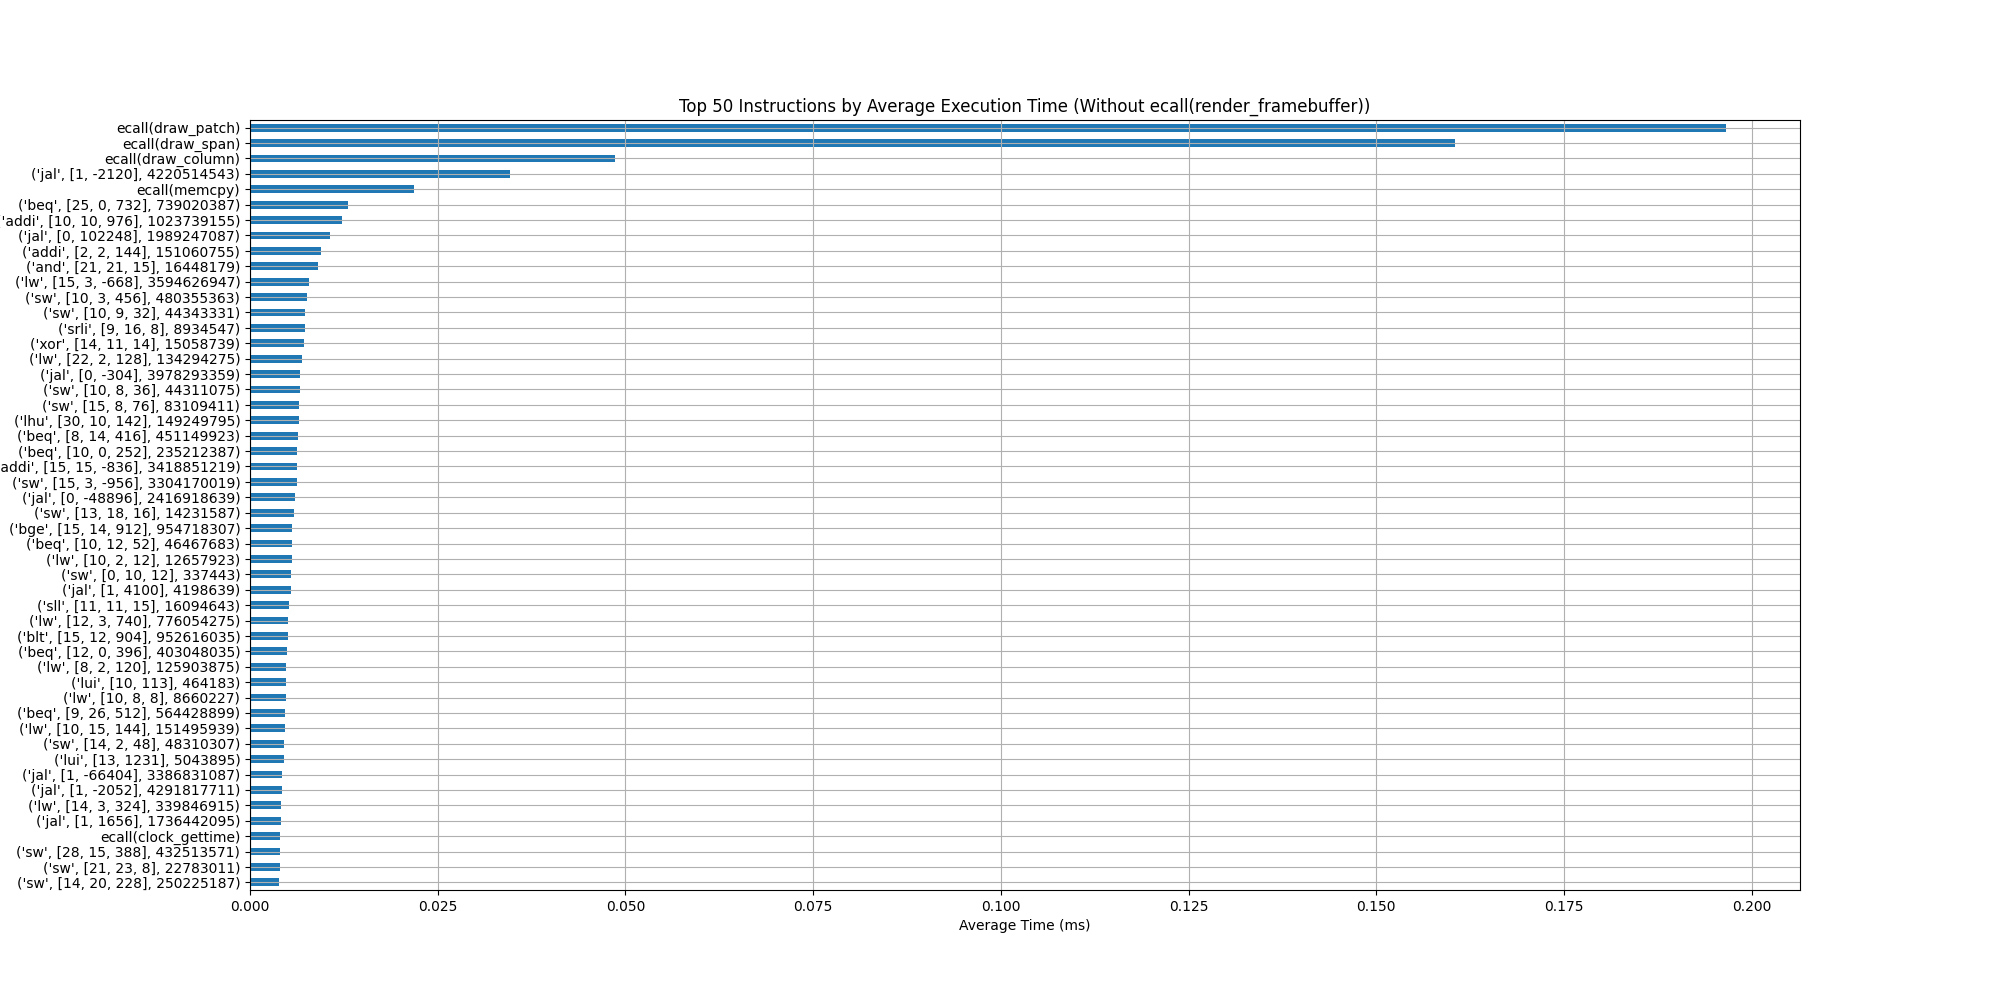

In [43]:
dsiabled_instr = "ecall(render_framebuffer)"

dd = prof_df[prof_df['instr_decoded_str'] != dsiabled_instr]

avg_time = dd.groupby('instr_decoded_str')['t'].mean()

top_k = 50

top_avg_time = avg_time.nlargest(top_k)

plt.figure(figsize=(20, 10))
top_avg_time.sort_values(ascending=True).plot(kind='barh')

plt.xlabel('Average Time (ms)')
plt.ylabel('Instruction')
plt.title(f'Top {top_k} Instructions by Average Execution Time (Without {dsiabled_instr})')
plt.grid()
plt.show()

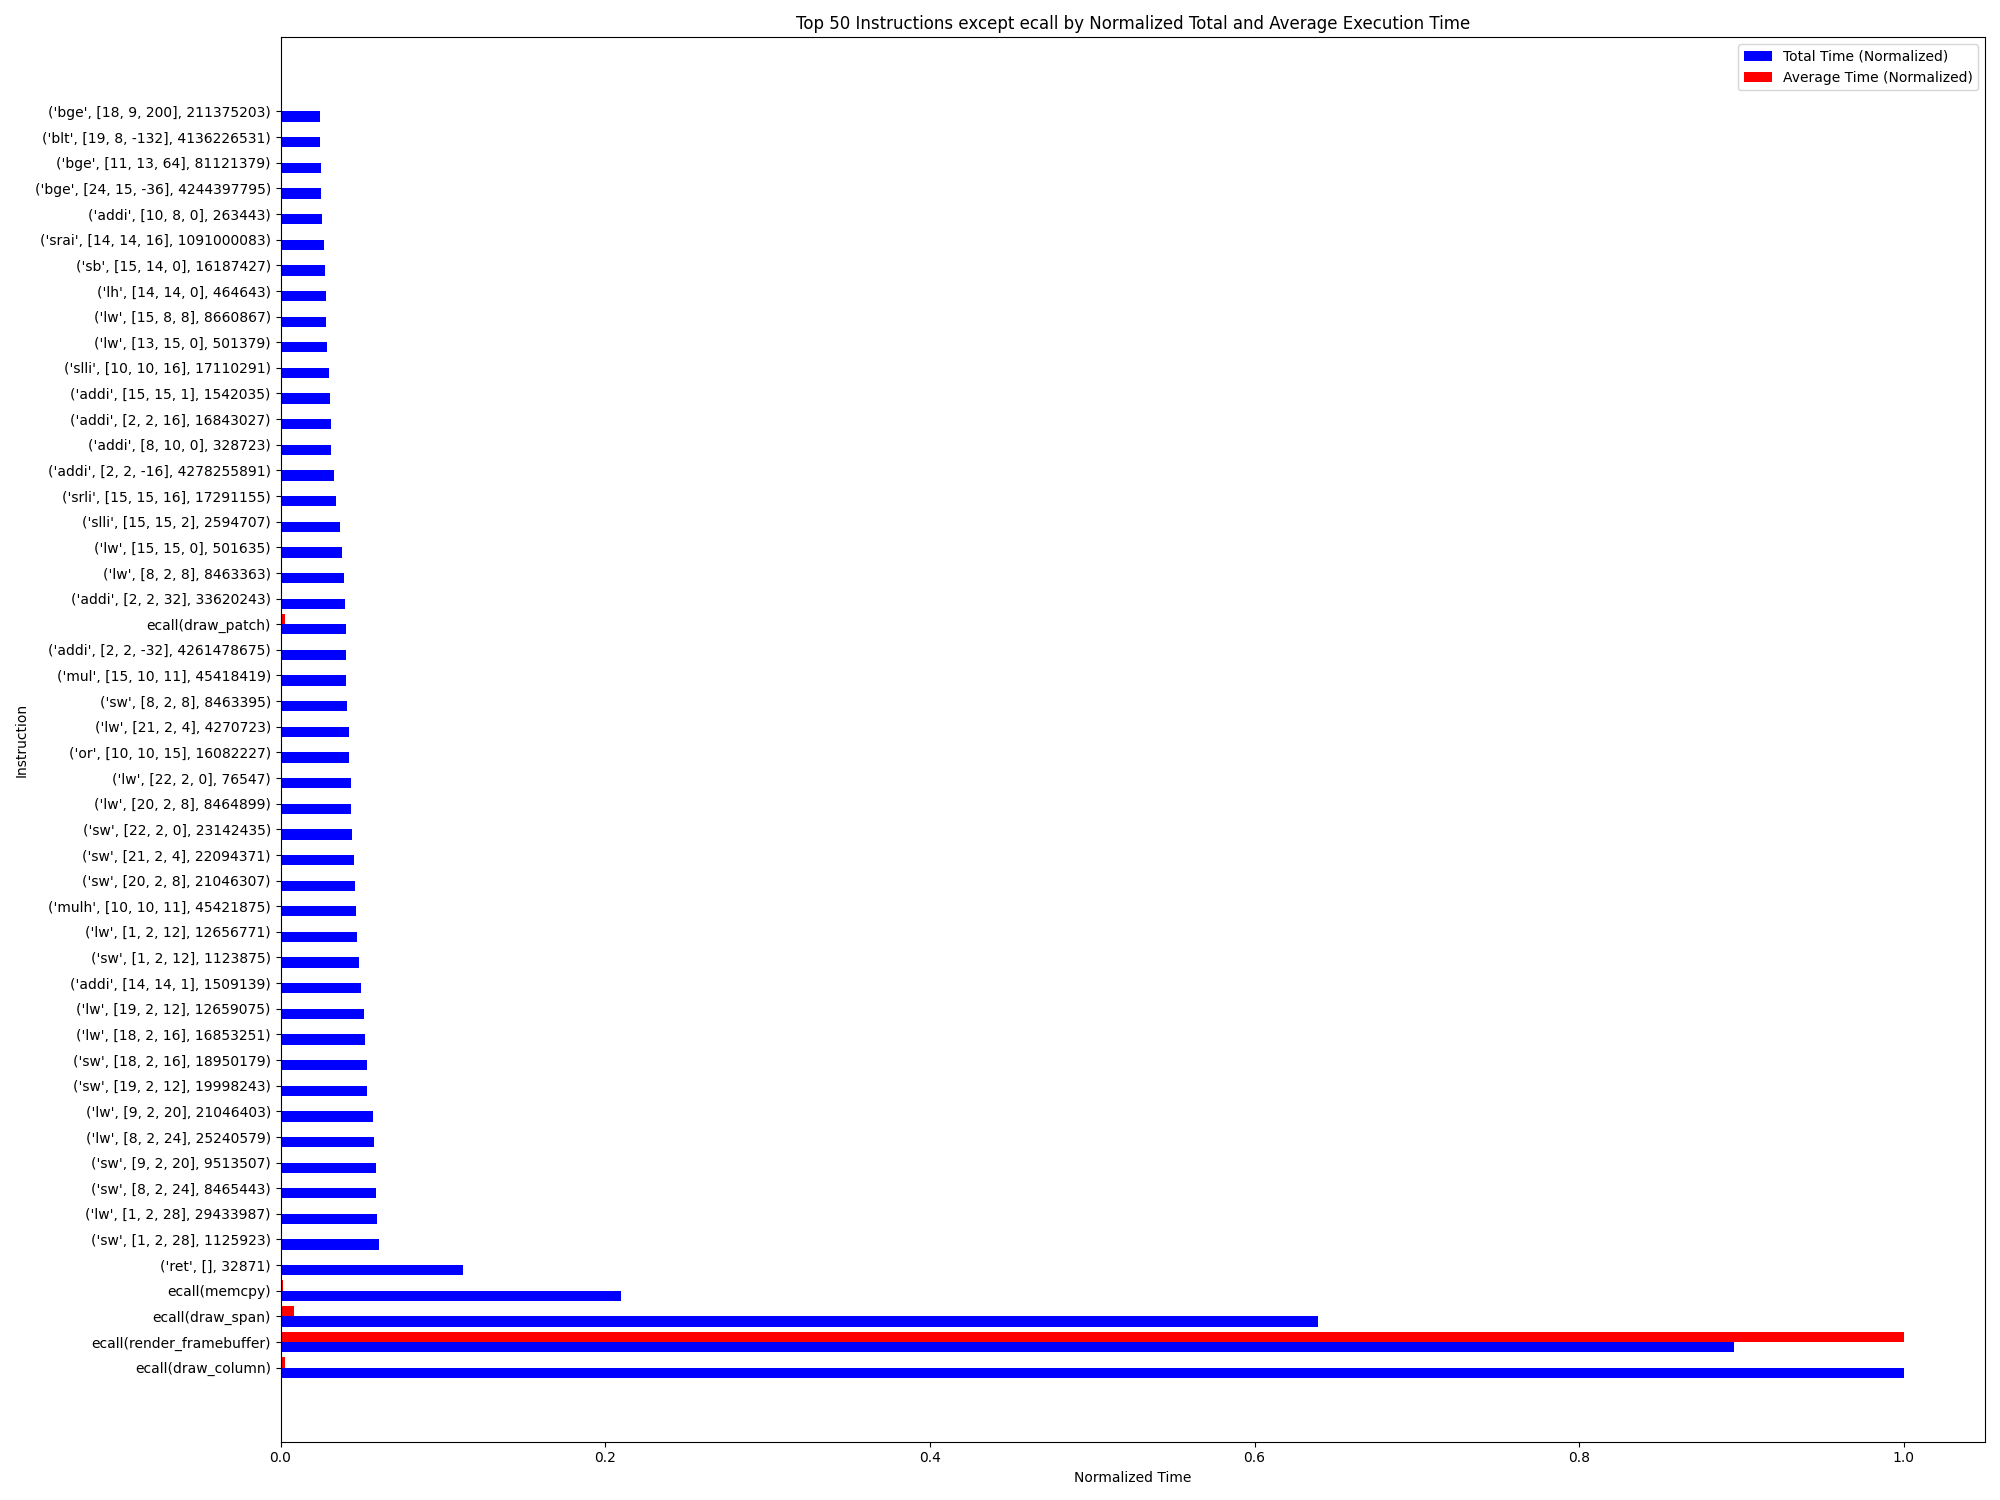

In [22]:
# Group by 'instr_decoded_str' and calculate total and average time
total_time = prof_df[prof_df['instr_decoded_str']!='(\'ecall\', [], 115)'].groupby('instr_decoded_str')['t'].sum()
avg_time = prof_df[prof_df['instr_decoded_str']!='(\'ecall\', [], 115)'].groupby('instr_decoded_str')['t'].mean()

# Define the number of top instructions to plot
top_k = 50

# Define a boolean to choose sorting method (True for total time, False for average time)
sort_by_total = True

# Select the top_k instructions by total or average time
if sort_by_total:
    top_total_time = total_time.nlargest(top_k)
    top_avg_time = avg_time.reindex(top_total_time.index)
else:
    top_avg_time = avg_time.nlargest(top_k)
    top_total_time = total_time.reindex(top_avg_time.index)

top_total_time_normalized = top_total_time /  top_total_time.max()
top_avg_time_normalized = top_avg_time / top_avg_time.max()

# Plotting in a single subplot with side-by-side bars
fig, ax = plt.subplots(figsize=(20, 15))

# Number of labels
labels = top_total_time.index

# Bar width and positions
bar_width = 0.4
index = np.arange(len(labels))

# Plot bars
bars_total = ax.barh(index, top_total_time_normalized, bar_width, label='Total Time (Normalized)', color='blue')
bars_avg = ax.barh(index + bar_width, top_avg_time_normalized, bar_width, label='Average Time (Normalized)', color='red')

# Add labels and title
ax.set_xlabel('Normalized Time')
ax.set_ylabel('Instruction')
ax.set_title(f'Top {top_k} Instructions except ecall by Normalized Total and Average Execution Time')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(labels)

# Add legend
ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

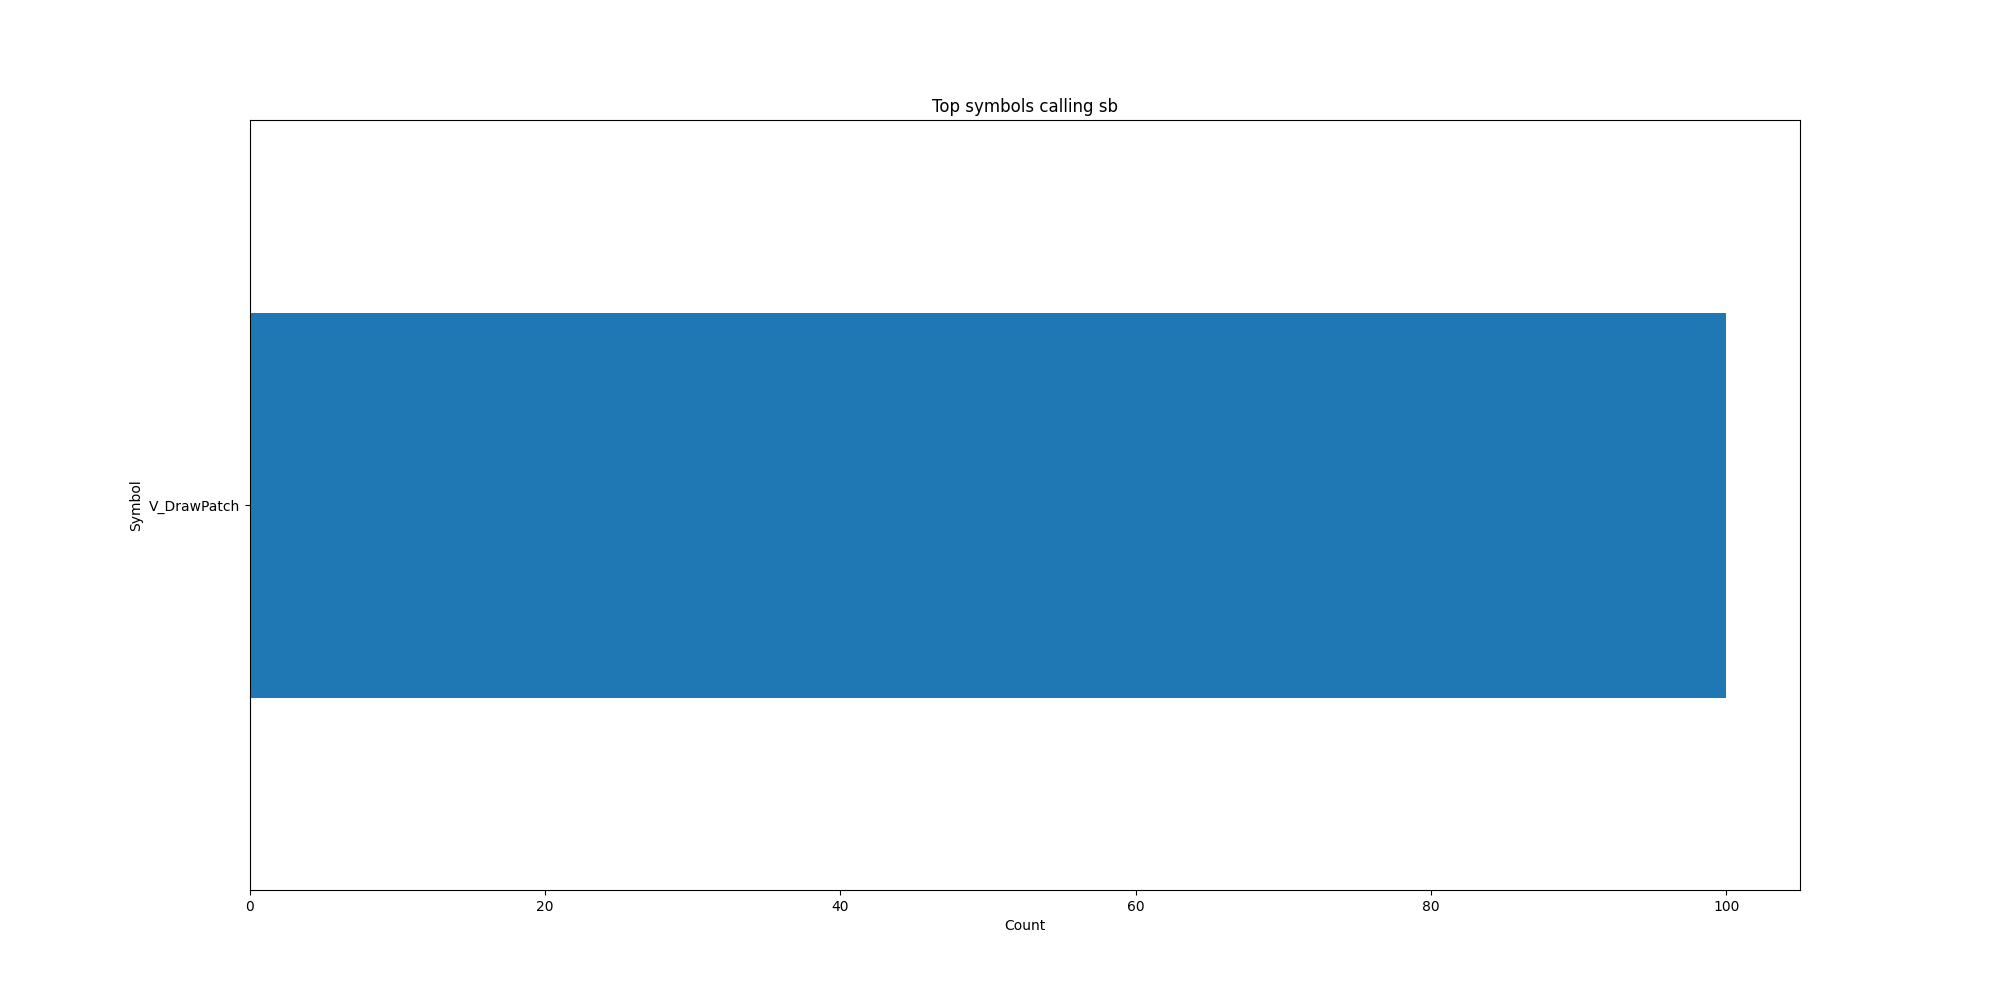

In [16]:
%matplotlib widget

symbol_counts = prof_df[prof_df['instr']==3970367523]['symbol'].value_counts()
symbol_percent = (symbol_counts / symbol_counts.sum()) * 100

top_symbol_percent = symbol_percent.head(50)

plt.figure(figsize=(20, 10))
top_symbol_percent.sort_values(ascending=True).plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Symbol')
plt.title('Top symbols calling sb')

plt.show()